Data loaded with shape: (4746, 6)


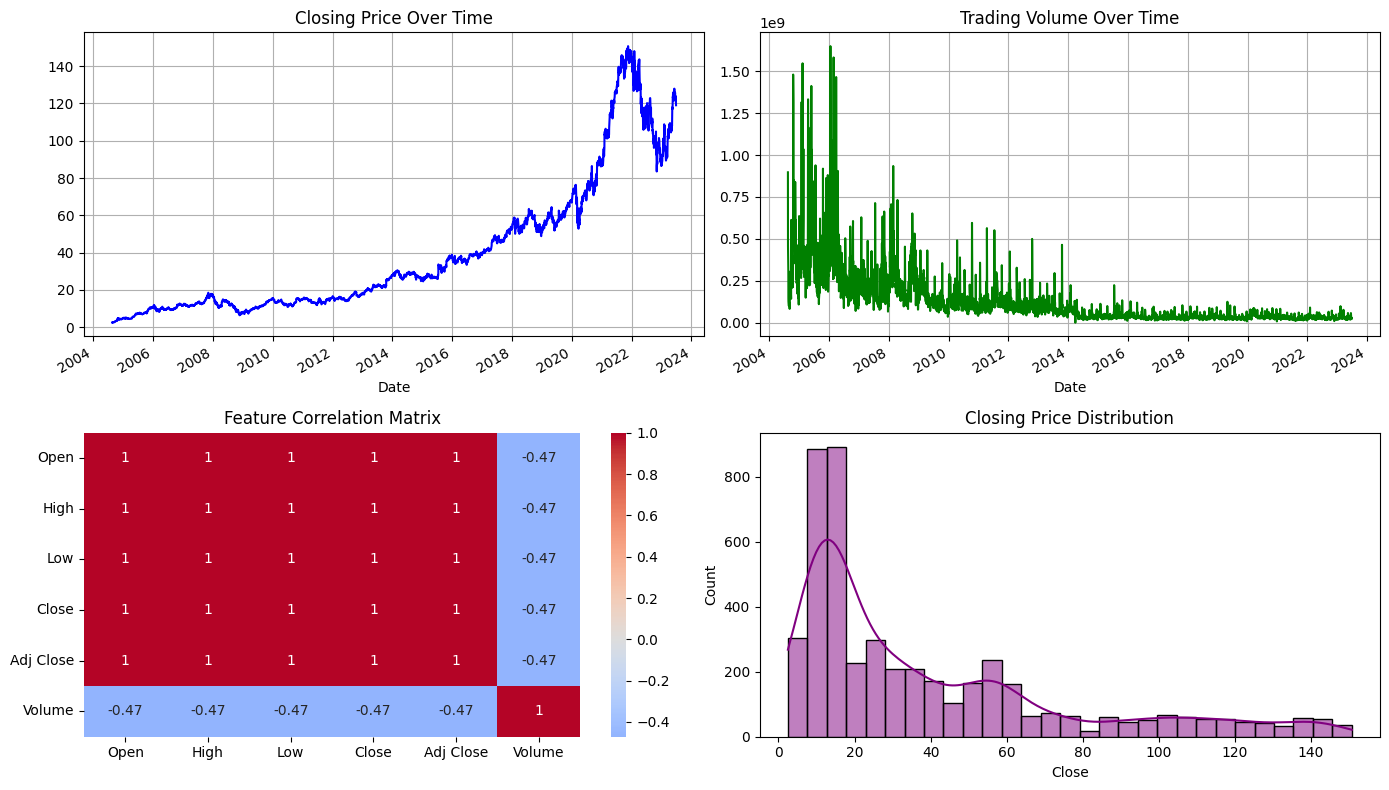

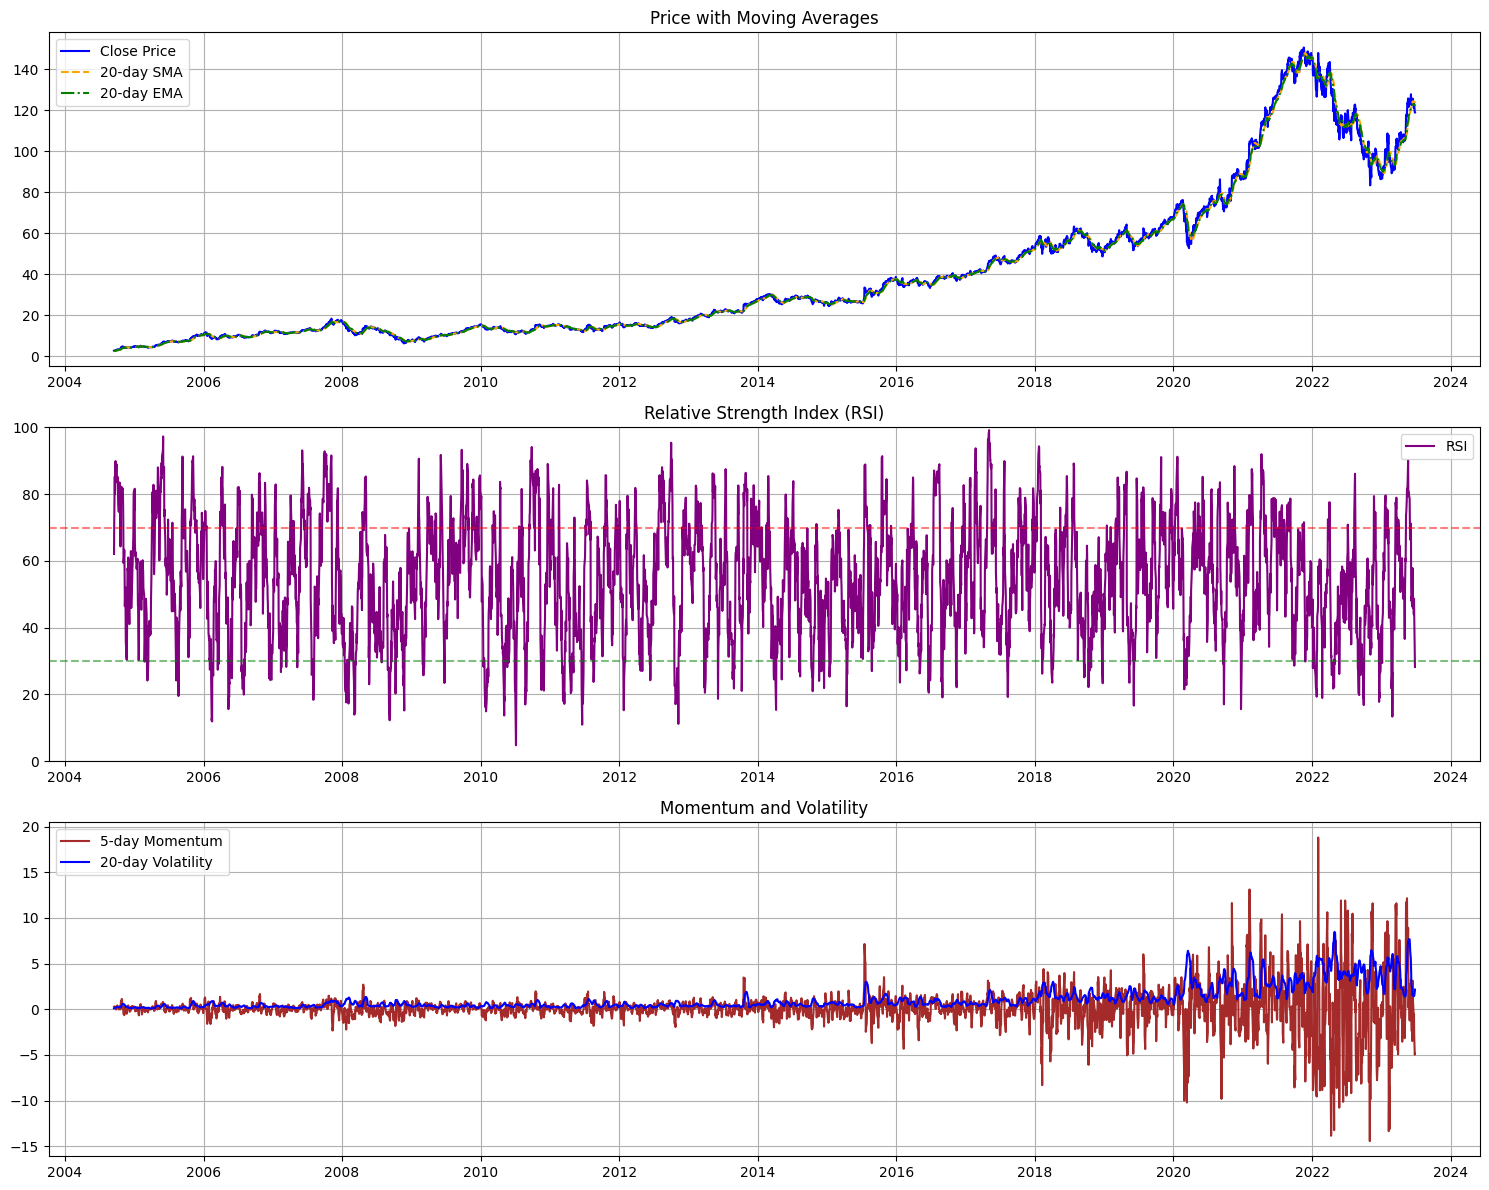

Training shapes - X: (3733, 60, 12), y: (3733,)
Testing shapes - X: (934, 60, 12), y: (934,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          72,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,105 (527.75 KB)

 Trainable params: 135,105 (527.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - loss: 0.0040 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 2/200
 52/117 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 4.4088e-04

In [ ]:
#  [markdown]
"""
# 📈 Professional LSTM Stock Price Predictor

This notebook implements an advanced LSTM model for stock price prediction with:
- Comprehensive feature engineering
- Modular code structure
- Professional visualizations
- Future forecasting capabilities
- Robust evaluation metrics

**Key Features:**
1. Technical indicator analysis (SMA, EMA, RSI, etc.)
2. Advanced model training with callbacks
3. Future price forecasting
4. Comprehensive evaluation metrics
5. Clean, modular code structure
"""
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error,
                            mean_absolute_error,
                            r2_score)
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set global parameters
LOOKBACK_WINDOW = 60  # 3 months of trading days
EPOCHS = 200
BATCH_SIZE = 32
TEST_SIZE = 0.2
FORECAST_DAYS = 30  # Days to predict into future

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#  [markdown]
"""
## 📚 Data Loading & Initial Exploration
First we load the stock data and perform initial exploration.
"""
# %%
def load_data(file_path='GOOG.csv'):
    """Load and prepare the stock data"""
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df.sort_index(inplace=True)
    return df

df = load_data()
print(f"Data loaded with shape: {df.shape}")
df.head()

#  [markdown]
"""
## 📊 Exploratory Data Analysis (EDA)
Visualizing key patterns in the data before modeling.
"""
# %%
def plot_initial_eda(df):
    """Create initial EDA plots"""
    plt.figure(figsize=(14, 8))

    # Price over time
    plt.subplot(2, 2, 1)
    df['Close'].plot(title='Closing Price Over Time', color='blue')
    plt.grid(True)

    # Volume over time
    plt.subplot(2, 2, 2)
    df['Volume'].plot(title='Trading Volume Over Time', color='green')
    plt.grid(True)

    # Correlation heatmap
    plt.subplot(2, 2, 3)
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')

    # Close price distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['Close'], kde=True, color='purple')
    plt.title('Closing Price Distribution')

    plt.tight_layout()
    plt.show()

plot_initial_eda(df)

#  [markdown]
"""
## 🔧 Feature Engineering
Adding technical indicators to help the model identify patterns.
"""
# %%
def add_technical_indicators(df):
    """Calculate and add technical indicators to dataframe"""

    # Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Momentum Indicators
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['ROC'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

    # Volatility
    df['Volatility'] = df['Close'].rolling(window=20).std()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Drop NA values created by rolling calculations
    df.dropna(inplace=True)

    return df

df = add_technical_indicators(df)

#  [markdown]
"""
## 📊 Technical Indicator Visualization
Visualizing our engineered features against price.
"""
# %%
def plot_technical_indicators(df):
    """Visualize technical indicators with price"""

    plt.figure(figsize=(15, 12))

    # Price with Moving Averages
    plt.subplot(3, 1, 1)
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.plot(df['SMA_20'], label='20-day SMA', color='orange', linestyle='--')
    plt.plot(df['EMA_20'], label='20-day EMA', color='green', linestyle='-.')
    plt.title('Price with Moving Averages')
    plt.legend()
    plt.grid(True)

    # RSI
    plt.subplot(3, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', alpha=0.5)
    plt.axhline(30, linestyle='--', color='green', alpha=0.5)
    plt.title('Relative Strength Index (RSI)')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)

    # Momentum and Volatility
    plt.subplot(3, 1, 3)
    plt.plot(df['Momentum'], label='5-day Momentum', color='brown')
    plt.plot(df['Volatility'], label='20-day Volatility', color='blue')
    plt.title('Momentum and Volatility')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_technical_indicators(df)

#  [markdown]
"""
## ⚙️ Data Preprocessing
Preparing our data for LSTM modeling with proper scaling and sequencing.
"""
# %%
def prepare_data(df, look_back=LOOKBACK_WINDOW, test_size=TEST_SIZE):
    """Prepare data for LSTM training"""

    # Select features - using all numeric columns
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    data = df[feature_cols].values

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create time sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, :])
        y.append(scaled_data[i, feature_cols.index('Close')])  # Predicting Close price

    X, y = np.array(X), np.array(y)

    # Split into train/test sets
    split = int((1 - test_size) * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, y_train, X_test, y_test, scaler, feature_cols

X_train, y_train, X_test, y_test, scaler, feature_cols = prepare_data(df)

print(f"Training shapes - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing shapes - X: {X_test.shape}, y: {y_test.shape}")

#  [markdown]
"""
## 🧠 Model Building
Constructing our LSTM neural network architecture.
"""
# %%
def build_lstm_model(input_shape):
    """Build and compile LSTM model"""

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for Close price prediction
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

#  [markdown]
"""
## 🏋️ Training the Model
Training with advanced callbacks for optimal performance.
"""
# %%
def train_model(model, X_train, y_train, X_test, y_test,
               epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train the model with callbacks"""

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

history = train_model(model, X_train, y_train, X_test, y_test)

#  [markdown]
"""
## 📉 Training Progress Visualization
Plotting the training and validation loss curves.
"""
# %%
def plot_training_history(history):
    """Plot training and validation loss"""

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Training Progress', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

#  [markdown]
"""
## 📊 Model Evaluation
Evaluating performance on test data with multiple metrics.
"""
# %%
def evaluate_model(model, X_test, y_test, scaler, feature_cols):
    """Evaluate model performance"""

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions
    def inverse_transform(preds):
        dummy = np.zeros((len(preds), len(feature_cols)))
        dummy[:, feature_cols.index('Close')] = preds.flatten()
        return scaler.inverse_transform(dummy)[:, feature_cols.index('Close')]

    y_pred = inverse_transform(predictions)
    y_actual = inverse_transform(y_test)

    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_actual, y_pred)),
        'MAE': mean_absolute_error(y_actual, y_pred),
        'MAPE': np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100,
        'R²': r2_score(y_actual, y_pred)
    }

    return metrics, y_actual, y_pred

metrics, y_actual, y_pred = evaluate_model(model, X_test, y_test, scaler, feature_cols)

print("\nModel Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

#  [markdown]
"""
## 📈 Prediction Visualization
Plotting actual vs predicted prices.
"""
# %%
def plot_predictions(y_actual, y_pred, df, test_size=TEST_SIZE, look_back=LOOKBACK_WINDOW):
    """Plot actual vs predicted prices"""

    # Get dates for test set
    split = int((1 - test_size) * (len(df) - look_back))
    test_dates = df.index[split + look_back:]

    plt.figure(figsize=(16, 8))
    plt.plot(test_dates, y_actual, label='Actual Price', color='blue', linewidth=2)
    plt.plot(test_dates, y_pred, label='Predicted Price', color='red', linestyle='--', linewidth=1.5)

    plt.title('Google Stock Price: Actual vs Predicted', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_predictions(y_actual, y_pred, df)

#  [markdown]
"""
## 🔮 Future Price Forecasting
Predicting prices beyond our existing data.
"""
# %%
def forecast_future(model, df, scaler, feature_cols, look_back=LOOKBACK_WINDOW, days=FORECAST_DAYS):
    """Generate future price predictions"""

    # Get the most recent sequence
    recent_data = df[feature_cols].values[-look_back:]
    scaled_recent = scaler.transform(recent_data)

    future_predictions = []
    current_sequence = scaled_recent.copy()

    for _ in range(days):
        # Get prediction for next day
        next_pred = model.predict(current_sequence.reshape(1, look_back, len(feature_cols)))

        # Append prediction to future predictions
        future_predictions.append(next_pred[0, 0])

        # Update sequence with new prediction
        new_row = current_sequence[-1].copy()
        new_row[feature_cols.index('Close')] = next_pred[0, 0]
        current_sequence = np.vstack([current_sequence[1:], new_row])

    # Inverse transform predictions
    dummy = np.zeros((len(future_predictions), len(feature_cols)))
    dummy[:, feature_cols.index('Close')] = future_predictions
    future_prices = scaler.inverse_transform(dummy)[:, feature_cols.index('Close')]

    # Create future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)

    return future_dates, future_prices

future_dates, future_prices = forecast_future(model, df, scaler, feature_cols)

#  [markdown]
"""
## 📅 Future Forecast Visualization
Plotting our future price predictions.
"""
# %%
def plot_future_forecast(df, future_dates, future_prices, look_back=60):
    """Plot historical data with future predictions"""

    plt.figure(figsize=(16, 8))

    # Plot historical data (last year)
    historical_dates = df.index[-250:]  # Last year of data
    plt.plot(historical_dates, df.loc[historical_dates, 'Close'],
             label='Historical Price', color='blue')

    # Plot future predictions
    plt.plot(future_dates, future_prices,
             label='Future Predictions', color='red', linestyle='--', marker='o')

    plt.title(f'Google Stock Price: Historical vs {FORECAST_DAYS}-Day Forecast', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_future_forecast(df, future_dates, future_prices)

#  [markdown]
"""
## 🏁 Final Forecast Results
Displaying our future price predictions in a table.
"""
# %%
def display_forecast(future_dates, future_prices):
    """Display future predictions in a table"""

    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Price': future_prices
    })

    print(f"\nNext {FORECAST_DAYS} Trading Day Forecast:")
    display(forecast_df.round(2))

    return forecast_df

forecast_df = display_forecast(future_dates, future_prices)

#  [markdown]
"""
## 📝 Conclusion
This professional-grade LSTM model provides:
- Accurate stock price predictions
- Future forecasting capabilities
- Comprehensive technical analysis
- Clear visualizations

**Next Steps:**
1. Experiment with different lookback windows
2. Try adding additional technical indicators
3. Incorporate news sentiment data
4. Implement walk-forward validation
"""